In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# 1. Carga y preparación de datos
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Verificar las formas originales
print("Formas originales:")
print(f"x_train_raw shape: {x_train_raw.shape}")
print(f"y_train_raw shape: {y_train_raw.shape}")

Formas originales:
x_train_raw shape: (60000, 28, 28)
y_train_raw shape: (60000,)


In [ ]:
# Normalización
x_train = x_train_raw.astype("float32") / 255.0
x_test = x_test_raw.astype("float32") / 255.0

In [ ]:
# Reshape para agregar el canal de color
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [ ]:
# División en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_raw, test_size=0.1, random_state=42
)

In [ ]:
# One-hot encoding SOLO UNA VEZ para cada conjunto
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test_raw, num_classes)

In [ ]:
# Verificar las formas después del procesamiento
print("\nFormas después del procesamiento:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Formas después del procesamiento:
x_train shape: (54000, 28, 28, 1)
y_train shape: (54000, 10)
x_val shape: (6000, 28, 28, 1)
y_val shape: (6000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [ ]:
# Crear un conjunto de validación
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [ ]:
# Configuración de aumento de datos
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.GaussianNoise(0.1)
])

In [ ]:
def create_optimized_model():
    inputs = keras.Input(shape=(28, 28, 3))

    # Aplicar aumento de datos (solo durante el entrenamiento)
    x = data_augmentation(inputs)

    # Primer bloque convolucional
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Tercer bloque convolucional
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten y capas densas
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Capa de salida
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def create_optimized_model():
    """Crea un modelo de red neuronal convolucional (CNN) optimizado para la clasificación de imágenes.

    El modelo sigue una arquitectura que incluye bloques convolucionales con normalización por lotes,
    activación ReLU y max-pooling, seguidos de capas densas y capas de dropout para regularización.
    También incorpora aumento de datos para mejorar la generalización.

    Capas del modelo:
    - `inputs = keras.Input(shape=(28, 28, 3))`: Capa de entrada que define la forma de las imágenes (28x28 píxeles con 3 canales de color).
      Nota: El conjunto de datos MNIST es de escala de grises (1 canal). Es posible que necesite ajustar la forma de la entrada (a (28, 28, 1))
      o convertir las imágenes MNIST a 3 canales si esta configuración es intencional para otros datasets.
    - `data_augmentation(...)`: Capa de aumento de datos que aplica rotaciones aleatorias (0.1 radianes),
      zoom aleatorio (0.1) y ruido gaussiano (0.1) durante el entrenamiento para hacer el modelo más robusto.

    Primer bloque convolucional:
    - `layers.Conv2D(32, (3, 3), padding='same')`: Aplica 32 filtros convolucionales de 3x3 píxeles con 'same' padding.
      Extrae características locales de bajo nivel.
    - `layers.BatchNormalization()`: Normaliza las activaciones de la capa anterior, lo que ayuda a estabilizar y acelerar el entrenamiento.
    - `layers.Activation('relu')`: Aplica la función de activación Rectified Linear Unit (ReLU), introduciendo no-linealidad.
    - `layers.Conv2D(32, (3, 3), padding='same')`: Segunda capa convolucional con 32 filtros para refinar las características.
    - `layers.BatchNormalization()`: Normalización por lotes.
    - `layers.Activation('relu')`: Activación ReLU.
    - `layers.MaxPooling2D((2, 2))`: Reduce la dimensionalidad de las características tomando el valor máximo en ventanas de 2x2 píxeles.

    Segundo bloque convolucional:
    - `layers.Conv2D(64, (3, 3), padding='same')`: Aumenta el número de filtros a 64 para capturar características más complejas.
    - `layers.BatchNormalization()`: Normalización por lotes.
    - `layers.Activation('relu')`: Activación ReLU.
    - `layers.Conv2D(64, (3, 3), padding='same')`: Segunda capa convolucional con 64 filtros.
    - `layers.BatchNormalization()`: Normalización por lotes.
    - `layers.Activation('relu')`: Activación ReLU.
    - `layers.MaxPooling2D((2, 2))`: Reducción de dimensionalidad.

    Tercer bloque convolucional:
    - `layers.Conv2D(128, (3, 3), padding='same')`: Aumenta el número de filtros a 128 para características de alto nivel.
    - `layers.BatchNormalization()`: Normalización por lotes.
    - `layers.Activation('relu')`: Activación ReLU.
    - `layers.MaxPooling2D((2, 2))`: Reducción de dimensionalidad.

    Capa de Flatten y capas densas:
    - `layers.Flatten()`: Transforma las características 3D resultantes de las capas convolucionales en un vector 1D.
    - `layers.Dropout(0.3)`: Apaga aleatoriamente el 30% de las neuronas de entrada durante el entrenamiento para prevenir el sobreajuste.
    - `layers.Dense(256)`: Capa densa (completamente conectada) con 256 unidades.
    - `layers.BatchNormalization()`: Normalización por lotes.
    - `layers.Activation('relu')`: Activación ReLU.
    - `layers.Dropout(0.3)`: Segunda capa de dropout para regularización.

    Capa de salida:
    - `layers.Dense(10, activation='softmax')`: Capa densa final con 10 unidades (una por cada clase de MNIST) y activación 'softmax',
      que produce una distribución de probabilidad sobre las 10 clases.

    Returns:
        `keras.Model`: El modelo CNN compilado y listo para el entrenamiento.
    """
    # El cuerpo de la función create_optimized_model() iría aquí, como se definió en la celda anterior.
    pass

In [ ]:
model = create_optimized_model()

In [ ]:
# 5. Compilar con learning rate optimizado y decay
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_mnist_model.h5', save_best_only=True)
]

In [ ]:
# 7. Entrenamiento
batch_size = 128
epochs = 50

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8228 - loss: 0.5563

380/380 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8230 - loss: 0.5555 - val_accuracy: 0.9722 - val_loss: 0.1003
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9714 - loss: 0.0932

380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.9714 - loss: 0.0931 - val_accuracy: 0.9811 - val_loss: 0.0616
Epoch 3/50
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9764 - loss: 0.0761

380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9764 - loss: 0.0761 - val_accuracy: 0.9850 - val_loss: 0.0522
Epoch 4/50
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9799 - loss: 0.0650

380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9799 - loss: 0.0650 - val_accuracy: 0.9870 - val_loss: 0.0414
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9825 - loss: 0.0579 - val_accuracy: 0.9839 - val_loss: 0.0526
Epoch 6/50
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9845 - loss: 0.0496

380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9845 - loss: 0.0496 - val_accuracy: 0.9894 - val_loss: 0.0269
Epoch 7/50
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9858 - loss: 0.0457

380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9858 - loss: 0.0457 - val_accuracy: 0.9924 - val_loss: 0.0241
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9855 - loss: 0.0467 - val_accuracy: 0.9907 - val_loss: 0.0294
Epoch 9/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9878 - loss: 0.0415 - val_accuracy: 0.9906 - val_loss: 0.0318
Epoch 10/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9878 - loss: 0.0379 - val_accuracy: 0.9926 - val_loss: 0.0253
Epoch 11/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9888 - loss: 0.0352 - val_accuracy: 0.9922 - val_loss: 0.0264
Epoch 12/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9891 - loss: 0.0336 - val_accuracy: 0.9904 - val_loss: 0.0306


In [ ]:
# 8. Evaluación
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9894 - loss: 0.0297
Test accuracy: 0.9908


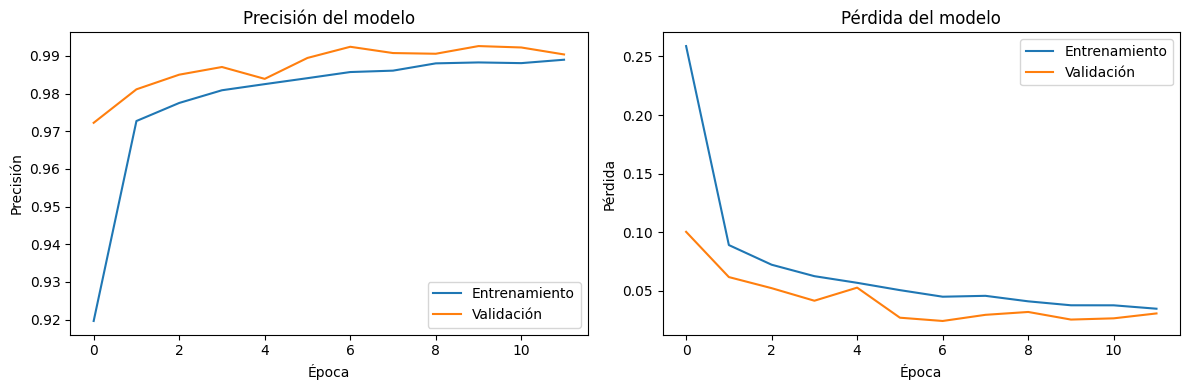

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Visualización de predicciones
def plot_predictions(model, x_data, y_data, n=10):
    # Seleccionar algunas muestras aleatorias
    indices = np.random.randint(0, len(x_data), n)
    x_samples = x_data[indices]
    y_samples = y_data[indices]

    # Obtener predicciones
    predictions = model.predict(x_samples)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_samples, axis=1)

    # Visualizar
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x_samples[i].reshape(28, 28), cmap='gray')
        color = 'green' if pred_classes[i] == true_classes[i] else 'red'
        plt.title(f"Pred: {pred_classes[i]}\nTrue: {true_classes[i]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


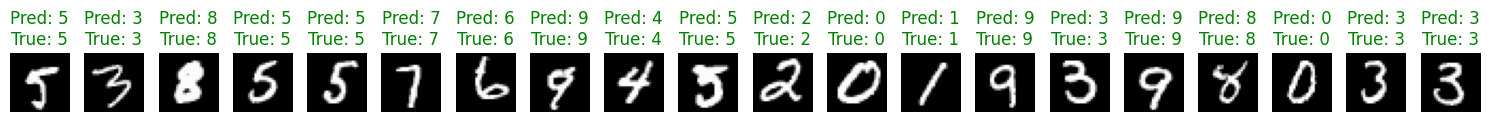

In [ ]:
# Mostrar algunas predicciones
predictions = plot_predictions(model, x_test, y_test, 20)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step


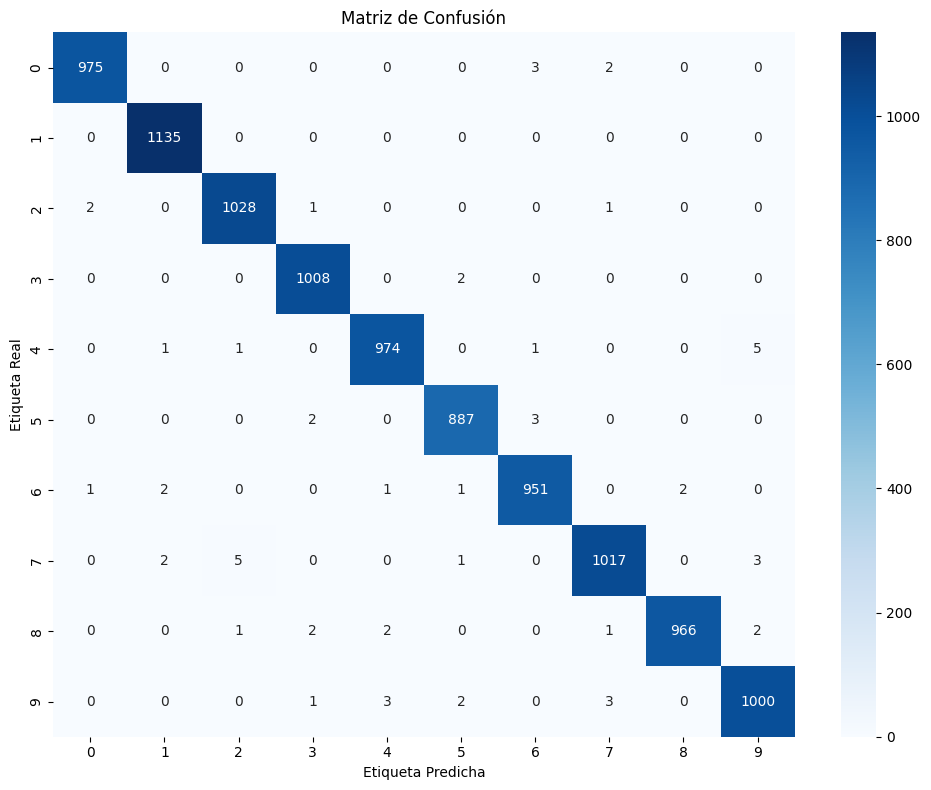

Accuracy: 0.9941
Misclassification: 0.0059
Accuracy para dígito 0: 0.9949
Accuracy para dígito 1: 1.0000
Accuracy para dígito 2: 0.9961
Accuracy para dígito 3: 0.9980
Accuracy para dígito 4: 0.9919
Accuracy para dígito 5: 0.9944
Accuracy para dígito 6: 0.9927
Accuracy para dígito 7: 0.9893
Accuracy para dígito 8: 0.9918
Accuracy para dígito 9: 0.9911


In [ ]:
# Obtener predicciones
predictions = model.predict(x_test)

# 2. Convertir a clases
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # Asumiendo que y_test está en formato one-hot

# 3. Crear y mostrar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred):
    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10),
                yticklabels=range(10))
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.tight_layout()
    plt.show()

    # Calcular algunas métricas adicionales de la matriz
    accuracy = np.trace(cm) / np.sum(cm)
    misclass = 1 - accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Misclassification: {misclass:.4f}")

    # Identificar la diagonal (predicciones correctas por clase)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(per_class_accuracy):
        print(f"Accuracy para dígito {i}: {acc:.4f}")

# Ahora sí llamamos a la función con las variables ya definidas
plot_confusion_matrix(y_true, y_pred)

In [ ]:
# Entrenar el modelo (asumiendo que ya compilaste 'model')
# history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

def guardar_modelo(modelo, nombre_archivo="modelo_optimizado.h5"):
    """Guarda el modelo en formato .h5 para su posterior uso."""
    modelo.save(nombre_archivo)
    print(f"Modelo guardado exitosamente como {nombre_archivo}")

# Ejecutar guardado
guardar_modelo(model)